<a href="https://colab.research.google.com/github/radhakrishnan-omotec/toenail-repo/blob/main/Sixth_Toenail_Diseases_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toenail Diseases Classification : 10 diseases classification using Image classification

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [5]:
!git clone https://github.com/radhakrishnan-omotec/toenail-repo.git

Cloning into 'toenail-repo'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 32 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 9.31 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [7]:
# STEP 1: Connect to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# STEP 2: Load the folder in the connected Google Drive
import os

# Change this path to the folder you want to analyze
folder_path = '/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/'


# Check if the folder exists
if not os.path.exists(folder_path):
    raise Exception(f"The folder {folder_path} does not exist. Please check the path.")
else:
    print("Folder Loaded Successfully")

Folder Loaded Successfully


In [9]:
import pathlib
# Define the directory path
data_dir = pathlib.Path('/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/')
# Specify the image file extensions to look for
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}
# Use pathlib to find all image files in the directory and subdirectories
image_files = [f for f in data_dir.rglob('*') if f.suffix.lower() in image_extensions]
# Count the number of image files
num_images = len(image_files)
print(f"Number of images: {num_images}")

Number of images: 4822


In [10]:
#------------ COUNT OF DATASET ----------------
Class1_Tineaunguium = list(data_dir.glob('Class 1 - Tinea unguium/*'))
print("Class 1 - Tinea unguium COUNT =",len(Class1_Tineaunguium))

Class2_Paronychia = list(data_dir.glob('Class 2 - Paronychia/*'))
print("Class 2 - Paronychia COUNT =",len(Class2_Paronychia))

Class3_IngrownToenail = list(data_dir.glob('Class 3 - Ingrown Toenail/*'))
print("Class 3 - Ingrown Toenail COUNT =",len(Class3_IngrownToenail))

Class4_NailPsoriasis = list(data_dir.glob('Class 4 - Nail Psoriasis/*'))
print("Class 4 - Nail Psoriasis COUNT =",len(Class4_NailPsoriasis))

Class5_Erythrasma = list(data_dir.glob('Class 5 - Erythrasma/*'))
print("Class 5 - Erythrasma COUNT =",len(Class5_Erythrasma))

Class6_ToenailMelanoma = list(data_dir.glob('Class 6 - Toenail Melanoma/*'))
print("Class 6 - Toenail Melanom COUNT =",len(Class6_ToenailMelanoma))

Class7_Onychodystrophy = list(data_dir.glob('Class 7 - Onychodystrophy/*'))
print("Class 7 - Onychodystrophy COUNT =",len(Class7_Onychodystrophy))

Class8_SubungualHematoma = list(data_dir.glob('Class 8 - Subungual Hematoma/*'))
print("Class 8 - Subungual Hematoma COUNT =",len(Class8_SubungualHematoma))

Class9_PincerNail = list(data_dir.glob('Class 9 - Pincer Nail/*'))
print("Class 9 - Pincer Nail COUNT =",len(Class9_PincerNail))

Class10_NailDystrophy = list(data_dir.glob('Class 10 - Nail Dystrophy/*'))
print("Class 10 - Nail Dystrophy COUNT =",len(Class10_NailDystrophy))


#-------------------------------------------------------------------

Class 1 - Tinea unguium COUNT = 451
Class 2 - Paronychia COUNT = 614
Class 3 - Ingrown Toenail COUNT = 480
Class 4 - Nail Psoriasis COUNT = 461
Class 5 - Erythrasma COUNT = 519
Class 6 - Toenail Melanom COUNT = 442
Class 7 - Onychodystrophy COUNT = 460
Class 8 - Subungual Hematoma COUNT = 475
Class 9 - Pincer Nail COUNT = 450
Class 10 - Nail Dystrophy COUNT = 470


After downloading, you should now have a copy of the dataset available. There are Thousands of total images:

Here are some Class 1 images:

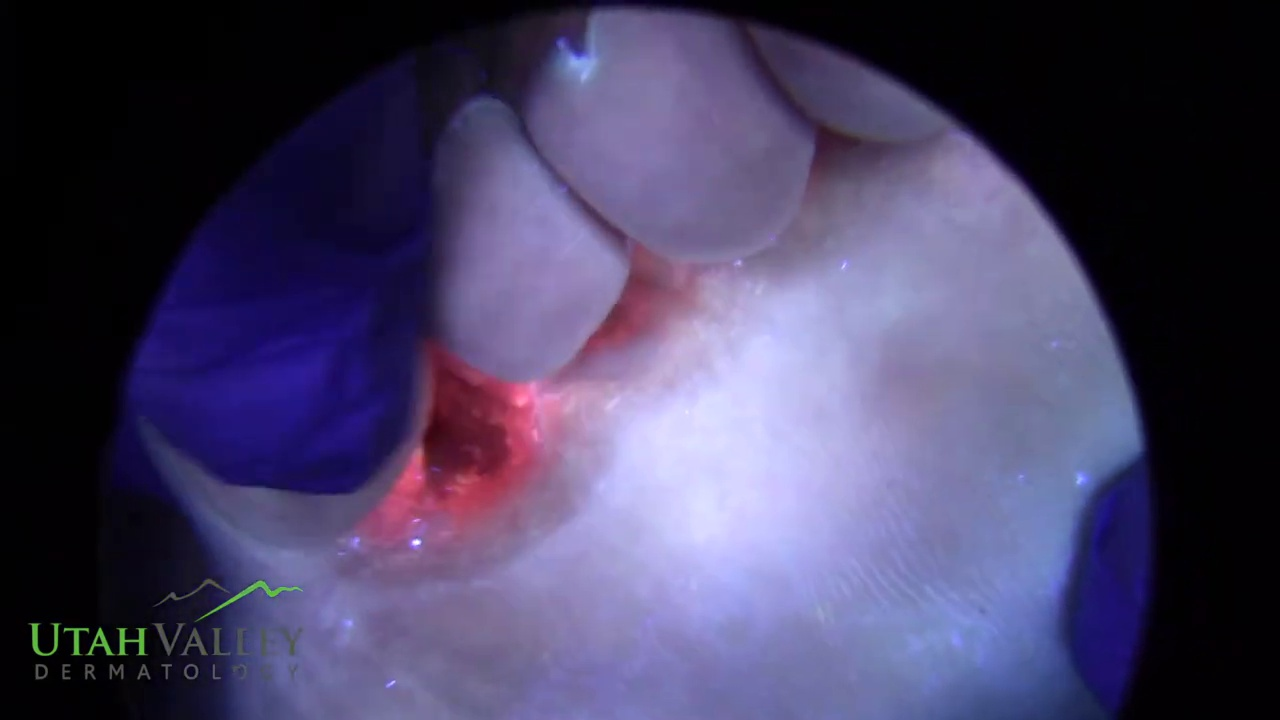

In [11]:
class1 = list(data_dir.glob('Class 5 - Erythrasma/*'))
PIL.Image.open(str(class1[0]))

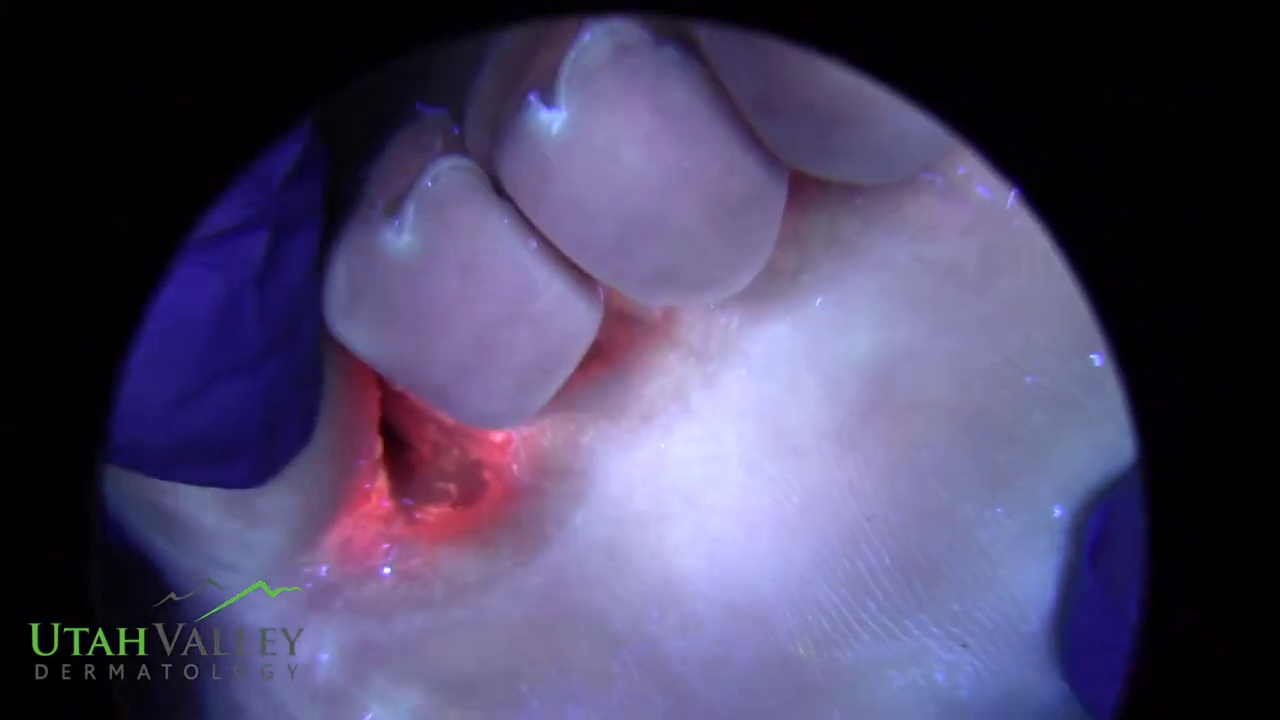

In [12]:
PIL.Image.open(str(class1[5]))

And some class 2:

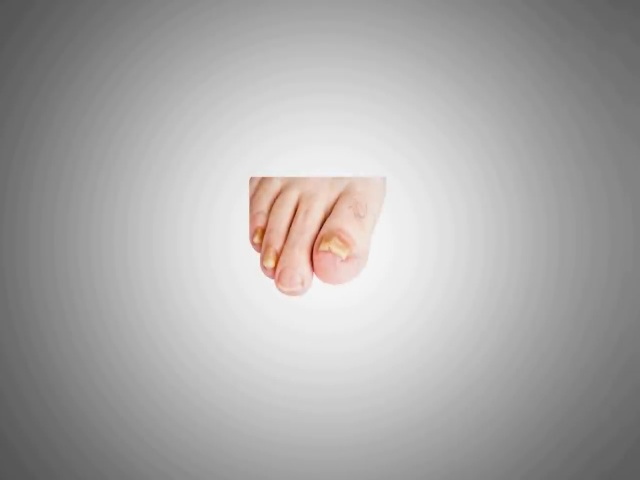

In [13]:
Class_2 = list(data_dir.glob('Class 1 - Tinea unguium/*'))
PIL.Image.open(str(Class_2[0]))

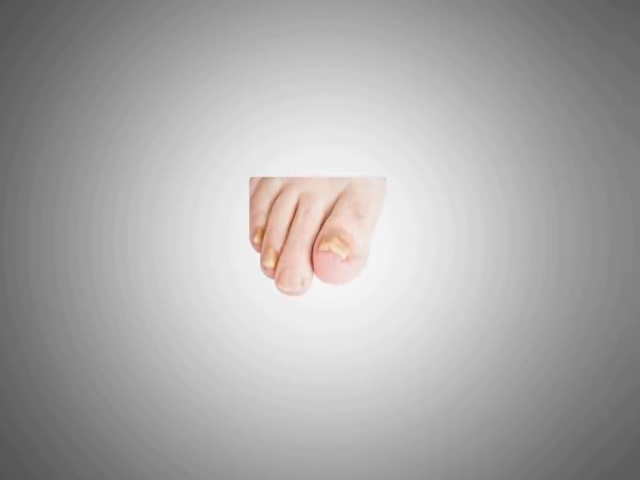

In [14]:
PIL.Image.open(str(Class_2[5]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [15]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4822 files belonging to 10 classes.
Using 3858 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4822 files belonging to 10 classes.
Using 964 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [18]:
class_names = train_ds.class_names
print(class_names)

['Class 1 - Tinea unguium', 'Class 10 - Nail Dystrophy', 'Class 2 - Paronychia', 'Class 3 - Ingrown Toenail', 'Class 4 - Nail Psoriasis', 'Class 5 - Erythrasma', 'Class 6 - Toenail Melanoma', 'Class 7 - Onychodystrophy', 'Class 8 - Subungual Hematoma', 'Class 9 - Pincer Nail']


## Visualize the data

Here are the first nine images from the training dataset:

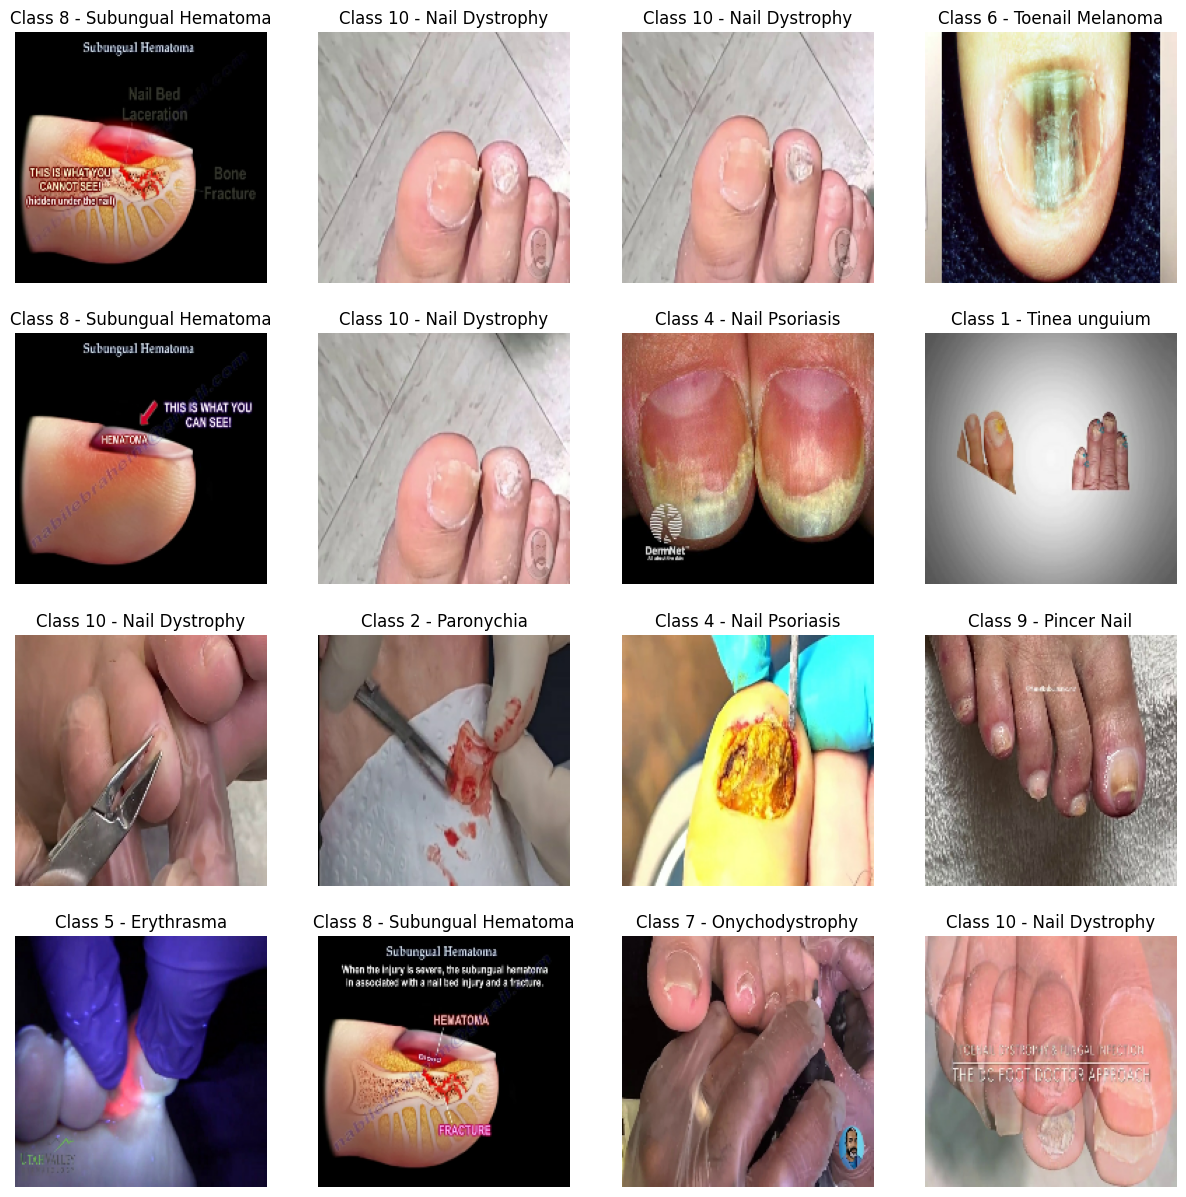

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [22]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00054452935 0.9972767


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [24]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,930 (15.22 MB)

 Trainable params: 3,989,930 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [27]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.7614 - loss: 0.8025 - val_accuracy: 0.9710 - val_loss: 0.1274
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9822 - loss: 0.0670 - val_accuracy: 0.9751 - val_loss: 0.0907
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9931 - loss: 0.0206 - val_accuracy: 0.9782 - val_loss: 0.0916
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9964 - loss: 0.0136 - val_accuracy: 0.9782 - val_loss: 0.0941
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9942 - loss: 0.0161 - val_accuracy: 0.9844 - val_loss: 0.0992
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9772 - val_loss: 0.1136
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9991 - loss: 0.0033 - val_accuracy: 0.9844 - val_loss: 0.1201
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9978 - loss: 0.0055 - val_accu

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

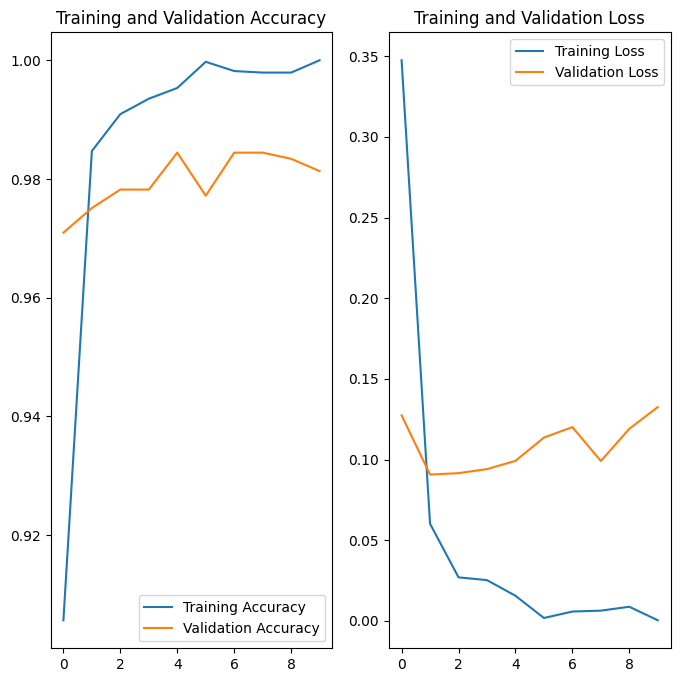

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [29]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

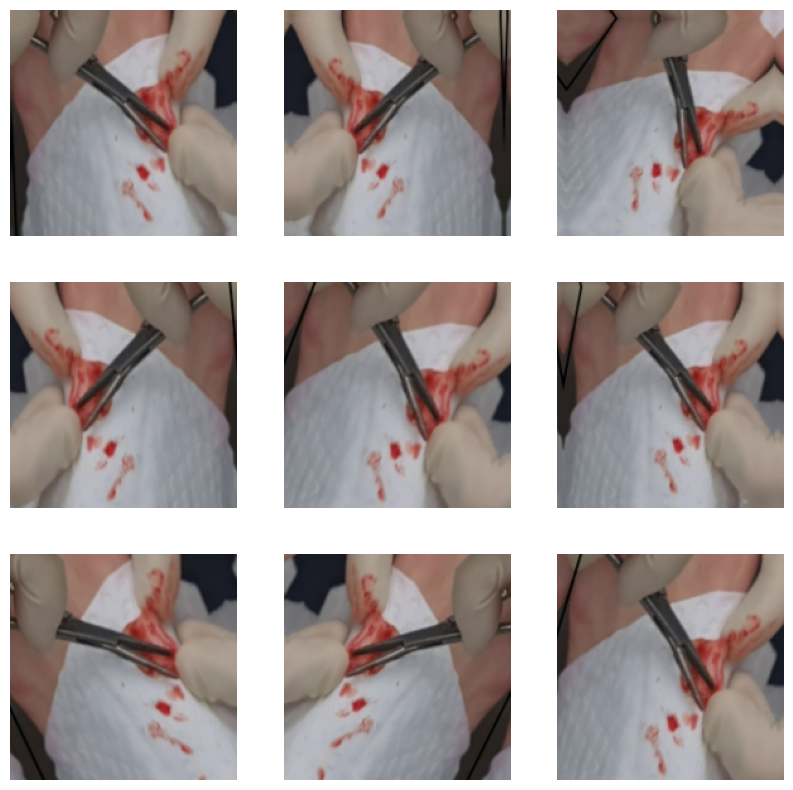

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [31]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.6110 - loss: 1.1917 - val_accuracy: 0.9481 - val_loss: 0.2438
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9546 - loss: 0.1850 - val_accuracy: 0.9087 - val_loss: 0.3145
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9649 - loss: 0.1360 - val_accuracy: 0.9575 - val_loss: 0.1991
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9808 - loss: 0.0910 - val_accuracy: 0.9689 - val_loss: 0.1436
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9861 - loss: 0.0587 - val_accuracy: 0.9658 - val_loss: 0.1694
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9829 - loss: 0.0522 - val_accuracy: 0.9782 - val_loss: 0.1220
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9861 - loss: 0.0484 - val_accuracy: 0.9564 - val_loss: 0.1883
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9875 - loss: 0.0368 - val_accu

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

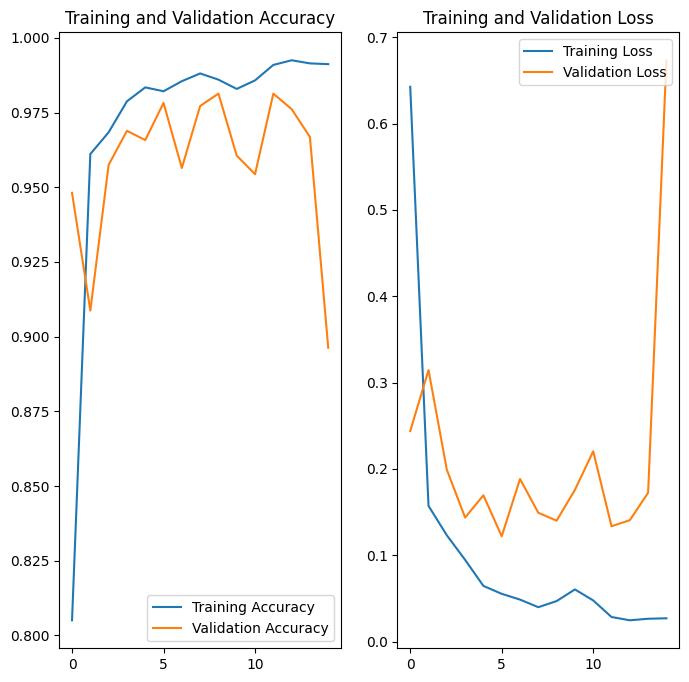

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [37]:
# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 1 - Tinea unguium/Class 1 - Tinea unguium_0055.jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Output the prediction result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
This image most likely belongs to Class 1 - Tinea unguium with a 100.00 percent confidence.


## Predict on Test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


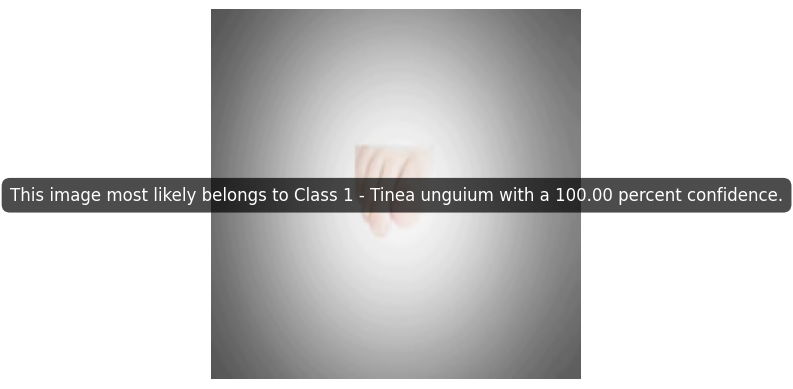

In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 1 - Tinea unguium/Class 1 - Tinea unguium_0055.jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


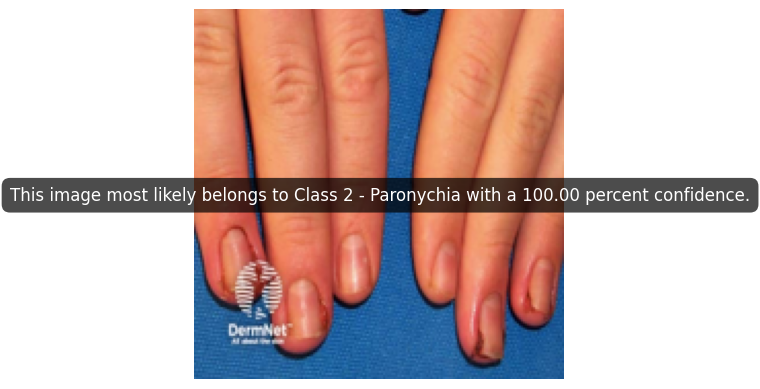

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 2 - Paronychia/3283 (1).jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


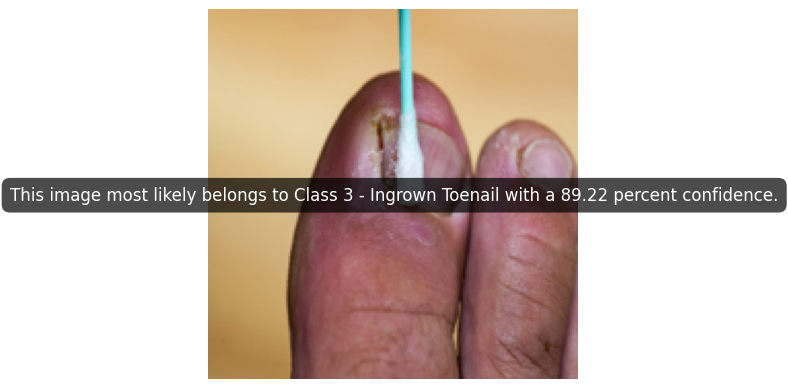

In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 3 - Ingrown Toenail/240_F_168764227_empn22EUebZ1ZENiR8fBr6t54FwrMcEr.jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


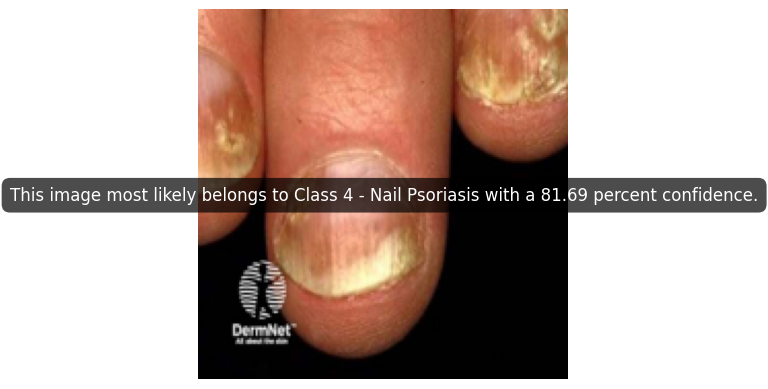

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 4 - Nail Psoriasis/3220 (1).jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


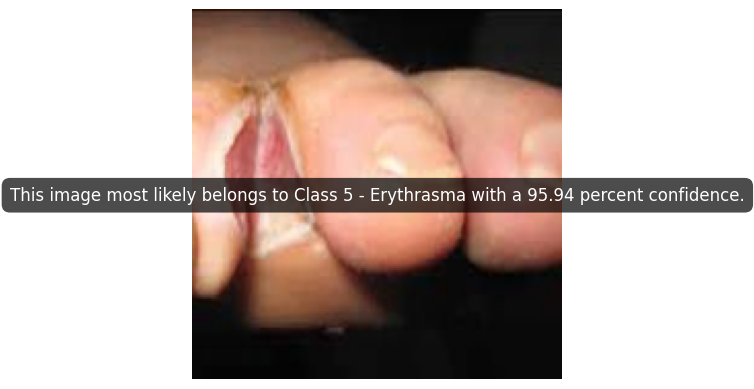

In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 5 - Erythrasma/Copy of download (1).jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


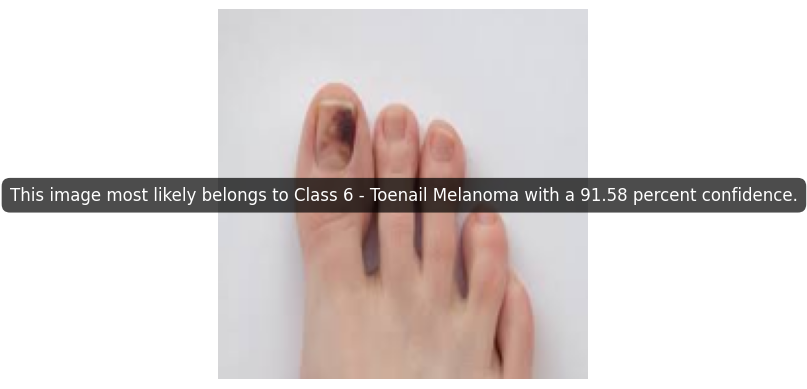

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 6 - Toenail Melanoma/Copy of download (1).jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


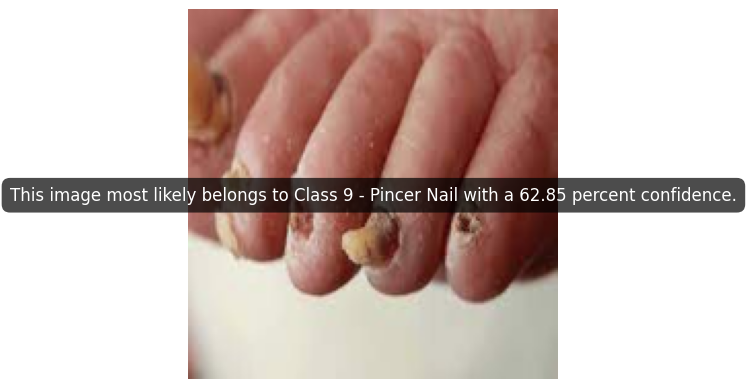

In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 7 - Onychodystrophy/Copy of download (1).jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


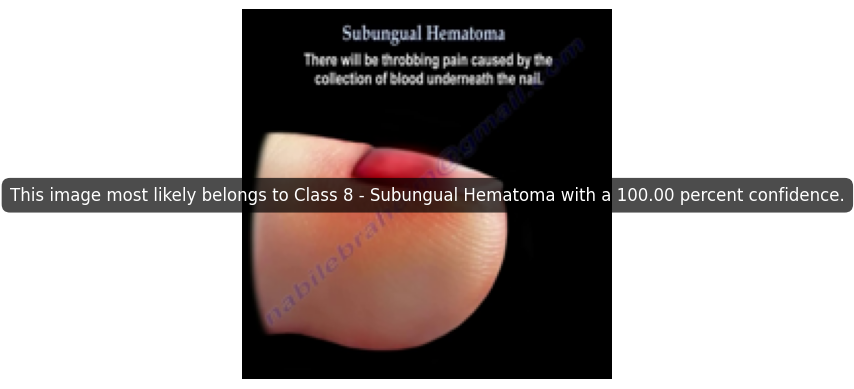

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 8 - Subungual Hematoma/Class 8 - Subungual Hematoma_0265.jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


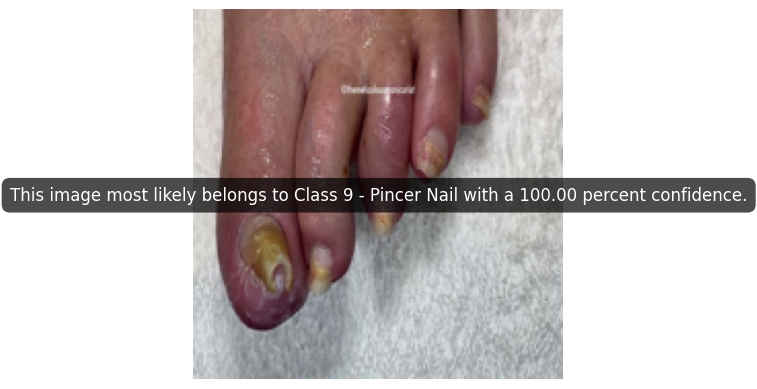

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 9 - Pincer Nail/Class 9 - Pincer Nail_0000.jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


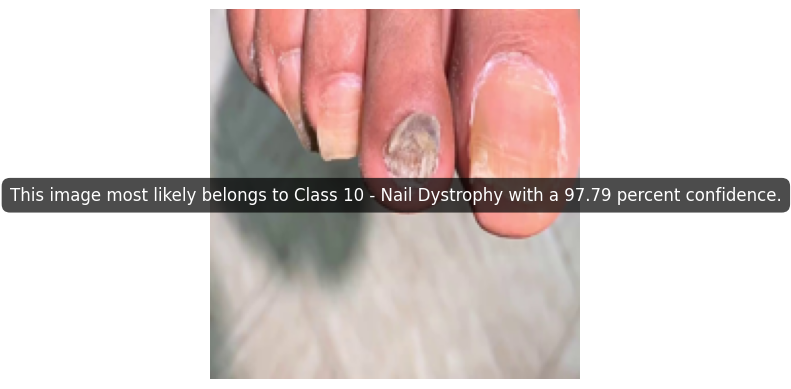

In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Define the path to your image file directly
test_path = "/content/drive/MyDrive/1.ALL-RESEARCH/0-TOE_NAIL_CLASSIFICATION/DATASET/Class 10 - Nail Dystrophy/Class 10 - Nail Dystrophy_0000.jpg"

# Load and preprocess the image
img = tf.keras.utils.load_img(test_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Get the prediction result
prediction_text = "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))

# Load the image using PIL for display
img_pil = Image.open(test_path).resize((img_width, img_height))

# Create a matplotlib figure
fig, ax = plt.subplots()
ax.imshow(img_pil)
ax.axis('off')  # Hide axes

# Add the prediction text
plt.text(
    img_width // 2, img_height // 2, prediction_text,
    color='white', fontsize=12, ha='center', va='center',
    bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
)

# Display the image with the text
plt.show()

## Prototype Testing

Creation of .h5 model and testing it with Gradio Library ( userinput.py) to add in Raspberry Pi devices.

In [ ]:
# Example of custom objects (if any)
from tensorflow.keras.utils import get_custom_objects

# Suppose you have a custom activation or layer
def custom_activation(x):
    return tf.nn.relu(x)

get_custom_objects().update({'custom_activation': custom_activation})

# Save the model, including custom objects
keras.saving.save_model(model, '/content/toenail-repo/Toenail_Diseases_Classifier.h5')

In [ ]:
model.save('/content/toenail-repo/Toenail_Diseases_Classifier.h5')

User Interface created using Gradio

In [2]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
import gradio as gr

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
import gradio as gr


classes_dict = {
0:'Class_1_-_Tinea_unguium',
1:'Class_2_-_Paronychia',
2:'AppClass_3_-_Ingrown_Toenail',
3:'Class_4_-_Nail_Psoriasis',
4:'Class_5_-_Erythrasma',
5:'Class_6_-_Toenail_Melanoma',
6:'Class_7_-_Onychodystrophy',
7:'Class_8_-_Subungual_Hematoma',
8:'Class_9_-_Pincer_Nail',
9:'Class_10_-_Nail_Dystrophy'
}


# Remove underscores from the dictionary values
classes_dict_cleaned = {key: value.replace('_', ' ') for key, value in classes_dict.items()}

# Now, classes_dict_cleaned contains the cleaned class names
# print(classes_dict_cleaned)


# Function to make predictions

def prediction(path, model, classes_dict):
    # Load and preprocess the image
    img = load_img(path, target_size=(256, 256))
    img_arr = img_to_array(img)
    processed_img_arr = preprocess_input(img_arr)

    # Expand image dimensions
    img_exp_dim = np.expand_dims(processed_img_arr, axis=0)

    # Make predictions using the model
    pred = np.argmax(model.predict(img_exp_dim))

    # Get the predicted class label
    predicted_class = classes_dict[pred]

    # Make predictions using the model
    prediction_probabilities = model.predict(img_exp_dim)
    pred_class_index = np.argmax(prediction_probabilities)
    predicted_probability = prediction_probabilities[0][pred_class_index]

    # Plot the input image
    plt.imshow(img)
    plt.axis('off')  # Remove axis
    plt.title(f"Predicted Class: {predicted_class}")
    plt.show()

    return img, predicted_class


# Function called by the UI

def predict(image):
    model = load_model("/content/toenail-repo/Toenail_Diseases_Classifier.h5") #the path to where the model is saved.

    # path = "C:\\Users\\OMOLP094\\Desktop\\Research Projects\\Soham Jariwala - Crop Health Monitoring Project\\Crop Health Monitoring - Final Implementation\\test\\CornCommonRust1.JPG"


    path = image.name

    # Call the prediction function
    img, predicted_class = prediction(path, model, classes_dict_cleaned)

    return img, predicted_class


# User Interface

def main():
    io = gr.Interface(
        fn=predict,
        inputs=gr.File(label="Upload the image of the toenail", file_types = ["image"]),
        outputs = [gr.Image(label = "Uploaded Image", width = 400, height = 400),
                   gr.Textbox(label="toenail Dieseases Overview")],
        allow_flagging="manual",
        flagging_options=["Save"],
        title="CNN based Common Toenail Diseases Classification",
        description="Classification of 10 Diseases Using Image Classification",
        theme = gr.themes.Soft()
    )

    io.launch(share=True)

if __name__ == "__main__":
    main()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5f173eb8ebb1db1778.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


----

## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_4_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

ValueError: Invalid Input name (sequential_1_input) for SignatureDef

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

Of the 20 classes —the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).

# TESTING

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing 

In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
import gradio as gr

In [ ]:
classes_dict = {0: 'Apple___Apple_scab',
 1: 'Apple___Black_Rot',
 2: 'Apple___Cedar_Apple_rust',
 3: 'Apple___Healthy',
 4: 'Blueberry___Healthy',
 5: 'Cherry_(including_sour)___Powdery_Mildew',
 6: 'Cherry_(including_sour)___Healthy',
 7: 'Corn_(maize)___Cercospora_Leaf_Spot Gray_Leaf_Spot',
 8: 'Corn_(maize)___Common_Rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___Healthy',
 11: 'Grape___Black_Rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_Llight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___Healthy',
 15: 'Orange___Haunglongbing_(Citrus_Greening)',
 16: 'Peach___Bacterial_Spot',
 17: 'Peach___Healthy',
 18: 'Pepper,_Bell___Bacterial_Spot',
 19: 'Pepper,_Bell___Healthy',
 20: 'Potato___Early_Blight',
 21: 'Potato___Late_Blight',
 22: 'Potato___Healthy',
 23: 'Raspberry___Healthy',
 24: 'Soybean___Healthy',
 25: 'Squash___Powdery_Mildew',
 26: 'Strawberry___Leaf_Scorch',
 27: 'Strawberry___Healthy',
 28: 'Tomato___Bacterial_Spot',
 29: 'Tomato___Early_Blight',
 30: 'Tomato___Late_Blight',
 31: 'Tomato___Leaf_Mold',
 32: 'Tomato___Septoria_Leaf_Spot',
 33: 'Tomato___Spider_Mites Two-Spotted_Spider_Mite',
 34: 'Tomato___Target_Spot',
 35: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 36: 'Tomato___Tomato_Mosaic_Virus',
 37: 'Tomato___Healthy'}


# Remove underscores from the dictionary values
classes_dict_cleaned = {key: value.replace('_', ' ') for key, value in classes_dict.items()}

# Now, classes_dict_cleaned contains the cleaned class names
# print(classes_dict_cleaned)


# Function to make predictions

def prediction(path, model, classes_dict):
    # Load and preprocess the image
    img = load_img(path, target_size=(256, 256))
    img_arr = img_to_array(img)
    processed_img_arr = preprocess_input(img_arr)

    # Expand image dimensions
    img_exp_dim = np.expand_dims(processed_img_arr, axis=0)

    # Make predictions using the model
    pred = np.argmax(model.predict(img_exp_dim))

    # Get the predicted class label
    predicted_class = classes_dict[pred]

    # Make predictions using the model
    prediction_probabilities = model.predict(img_exp_dim)
    pred_class_index = np.argmax(prediction_probabilities)
    predicted_probability = prediction_probabilities[0][pred_class_index]

    # Plot the input image
    plt.imshow(img)
    plt.axis('off')  # Remove axis
    plt.title(f"Predicted Class: {predicted_class}")
    plt.show()

    return img, predicted_class


# Function called by the UI

def predict(image):
    model = load_model("\\content\\sample_data\\crop_health_monitoring_model.h5")


    # path = "C:\\Users\\OMOLP094\\Desktop\\Research Projects\\Soham Jariwala - Crop Health Monitoring Project\\Crop Health Monitoring - Final Implementation\\test\\CornCommonRust1.JPG"
    path = "\\content\\sample_data\\TomatoHealthy4.JPG"

    path = image.name

    # Call the prediction function
    img, predicted_class = prediction(path, model, classes_dict_cleaned)

    return img, predicted_class


# User Interface

def main():
    io = gr.Interface(
        fn=predict,
        inputs=gr.File(label="Upload the image of the leaf of the plant or crop", file_types = ["image"]),
        outputs = [gr.Image(label = "Uploaded Image", width = 400, height = 400),
                   gr.Textbox(label="Crop Health Overview")],
        allow_flagging="manual",
        flagging_options=["Save"],
        title="CNN-Powered Crop Health Monitoring System",
        description="Effortlessly monitor crop health with our CNN-powered system.",
        theme = gr.themes.Soft()
    )

    io.launch(share=True)

if __name__ == "__main__":
    main()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://532e17c7449a3c4f8a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
